In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requi

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt

from datasets import load_dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load the dataset
celeb = load_dataset("nielsr/CelebA-faces", streaming=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
limit = 60_000  # Choose amount of samples from dataset
images = []
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(178),
    transforms.Resize(64)
])
for i, x in enumerate(celeb['train']):
  images.append(transform(x['image']).to(device))
  if i > limit:
    break

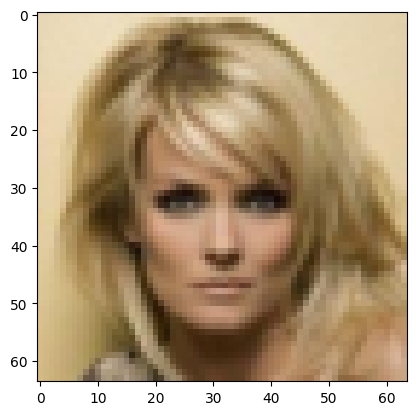

In [ ]:
plt.imshow(images[4].cpu().permute(1, 2, 0))

In [ ]:
batch_size = 64
train_dataloader = DataLoader(images, batch_size=batch_size, shuffle=True)

In [ ]:
# Single convololution block
def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 32), # (32, 32)
            conv_block(32, 64),          # (16, 16)
            conv_block(64, 128),         # ( 8,  8)
            conv_block(128, 256),        # ( 4,  4)
            conv_block(256, 512),        # ( 2,  2)
            conv_block(512, 1024),       # ( 1,  1)
        )
        self.mu = nn.Linear(1024, latent_dims)
        self.logvar = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = x.reshape(bs, -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return (mu, logvar)

In [ ]:
# Single transpose convolution layer
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=4,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]
    if with_act:  # Controling this will be handy later
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels, latent_dims):
        super().__init__()

        self.linear = nn.Linear(latent_dims, 1024) # ( 1,  1)
        self.t_conv_layers = nn.Sequential(
            conv_transpose_block(1024, 512),  # ( 2,  2)
            conv_transpose_block(512, 256),   # ( 4,  4)
            conv_transpose_block(256, 128),   # ( 8,  8)
            conv_transpose_block(128, 64),    # (16, 16)
            conv_transpose_block(64, 32),     # (32, 32)
            conv_transpose_block(32, out_channels, with_act=False), # (64, 64)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)
        x = x.reshape((bs, 1024, 1, 1))
        x = self.t_conv_layers(x)
        x = self.sigmoid(x)
        return x

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels, latent_dims)

    def encode(self, x):
        # Returns mu, log_var
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Obtain parameters of the normal (Gaussian) distribution
        mu, logvar = self.encode(x)

        # Sample from the distribution
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # Decode the latent point to pixel space
        reconstructed = self.decode(z)

        # Return the reconstructed image, and also the mu and logvar
        # so we can compute a distribution loss
        return reconstructed, mu, logvar

    def sample(self, mu, std):
        # Reparametrization trick
        # Sample from N(0, I), translate and scale
        eps = torch.randn_like(std)
        return mu + eps * std

In [ ]:
def vae_loss(batch, reconstructed, mu, logvar, kl_weight=1):
    bs = batch.shape[0]

    # Reconstruction loss from the pixels - 1 per image
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none",
    ).sum(dim=-1)

    # KL-divergence loss, per input image
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1) * kl_weight

    # Combine both losses and get the mean across images
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [ ]:
def train_vae(model, num_epochs=10, lr=1e-4, kl_weight=1):
    model = model.to(device)
    losses = {
        "loss": [],
        "reconstruction_loss": [],
        "kl_loss": [],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model
            reconstructed, mu, logvar = model(batch)

            # Compute the losses
            loss, reconstruction_loss, kl_loss = vae_loss(
                batch, reconstructed, mu, logvar, kl_weight
            )

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses["loss"].append(loss.item())
            losses["reconstruction_loss"].append(
                reconstruction_loss.mean().item()
            )
            losses["kl_loss"].append(kl_loss.mean().item())

            # Update model parameters based on the total loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [ ]:
vae_model = VAE(in_channels=3, latent_dims=128).to(device)

In [ ]:
losses = train_vae(vae_model, num_epochs=3, lr=0.005, kl_weight=0.25)

Training:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

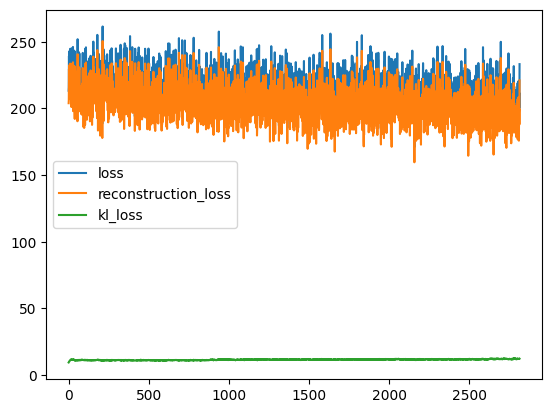

In [ ]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

In [ ]:
# Generate samples from normal distribution
num_images = 3
z = torch.normal(0, 1, size=(num_images, 128))
vae_model.eval()
with torch.inference_mode():
  vae_decoded = vae_model.decode(z.to(device))

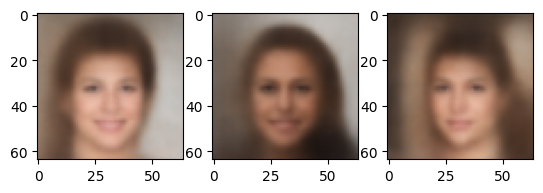

In [ ]:
fig, axarr = plt.subplots(1, num_images)
for i, image in enumerate(vae_decoded):
  axarr[i].imshow(image.permute(1, 2, 0).cpu())

plt.show()

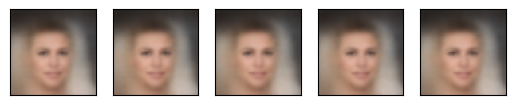

In [ ]:
# Exploring latent space
# Example:
# locked_cord=26 - Age
locked_cord = 52
num_steps = 5

z = torch.normal(0, 1, size=(1, 128)).to(device)
z[0, locked_cord] = -1

fig, axarr = plt.subplots(1, num_steps)

plt.xticks([])

vae_model.eval()
with torch.inference_mode():
  for i in range(num_steps):
    gen_image = vae_model.decode(z)[0]

    axarr[i].set_xticks([])
    axarr[i].set_yticks([])

    axarr[i].imshow(gen_image.permute(1, 2, 0).cpu())

    z[0, locked_cord] += 2.0 / num_steps

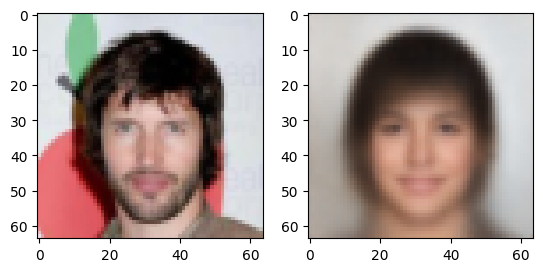

In [ ]:
# Take sample from dataset
vae_model.eval()
fig, axarr = plt.subplots(1, 2)
with torch.inference_mode():
  sample = next(iter(train_dataloader))[10][None, :].to(device)
  axarr[0].imshow(sample[0].permute(1, 2, 0).cpu())

  fake = vae_model(sample)[0][0]
  axarr[1].imshow(fake.permute(1, 2, 0).cpu())
plt.show()

In [ ]:
# Save the model
torch.save(vae_model.state_dict(), '/content/drive/MyDrive/celeb_vae_model_weights.pth')